# Portofolio:

## Business Understanding

### Introduction

A fitness center offers comprehensive facilities and training programs to help customers achieve their fitness goals. Currently, they are running an attractive promotional program by offering a 99% discount on the first month's membership fee for new sign-ups. The aims of this coupon program is to:
- increase member growth
- increase long term profit
- build a loyal customer

The marketing team wants to know customer lifetime value by understanding how long customers will stop visiting the fitness center using the survival analysis methodology. Churn is a tricky case. Although we say the customer is a churn already, there is still a chance to win back even old customers. Our marketing team definition for churn is if customers don't visit the fitness center in last six months, they assume that the customers are churn. It means, churn is for customers that don't visit for more than six months and not churn is for customers that still visit in last six months.

Information we need to know:
- subscription price: IDR 199.000
- gross profit: 55%
- first month discount: 99%

In [1]:
info = {'price': 199000,
        'gross_profit': 0.55,
        'first_month_discount': 0.99}

### Objectives

The aim of this project is to understand:
- the customers behaviour after signup and using their 99% discount on the first month membership,
- how long customer will survive from churn,
- what is the customer lifetime value,
- what is the CLTV:CAC ratio, and
- does age influence the duration of survival.

### Tools and Dataset Needed

The technologies used for this project is Python with its library such as numpy, pandas, matplotlib, seaborn, and lifeliness. The dataset contains few variables like customer_id, first_visit, last_visit, and age.

### Methodology

The survival analysis has some steps to do. All variables we need are time to event where this variable explains how long until the event occurs, target variable where this variable explains whether or not the event occurs until the study ends (it's called right cencored), and other variables that has correlation with the target.

We'll make churn variable by using if logic. 1 if last_visit < (query_time - six months) else 0 where 1 is churn and 0 is not churn.

the CLTV formula we adjust for this case:

$$CLTV = {Price * Gross \ Profit * Average \ Lifetime} $$

Where:
- Transaction means customers pays the bill (counted per each month)
- Price is the subscription price
- Gross Profit is a profit after all expenses
- Average Lifetime is the average duration before they do churn.

## Data Understanding

### Data Acquisition

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines

In [3]:
dataset = pd.read_csv('data/fitness_10-2024.csv')

In [4]:
print(dataset.head())

   customer_id register_date  last_visit  age
0         1001    2023-09-29  2023-10-21   27
1         1007    2023-11-28  2023-12-19   35
2         1011    2024-02-25  2024-03-20   28
3         1012    2023-07-30  2023-08-23   22
4         1033    2023-10-03  2023-10-22   29


### Data Profiling

In [5]:
# dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    1476 non-null   int64 
 1   register_date  1476 non-null   object
 2   last_visit     1476 non-null   object
 3   age            1476 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.3+ KB


The register_date and last_visit are still object type, so we will correct it later.

In [6]:
# missing values
dataset.isnull().sum()

customer_id      0
register_date    0
last_visit       0
age              0
dtype: int64

In [7]:
# duplicated values
dataset.duplicated().sum()

np.int64(0)

In [8]:
# correct wrong format
dataset['register_date'] = pd.to_datetime(dataset['register_date'])
dataset['last_visit'] = pd.to_datetime(dataset['last_visit'])

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    1476 non-null   int64         
 1   register_date  1476 non-null   datetime64[ns]
 2   last_visit     1476 non-null   datetime64[ns]
 3   age            1476 non-null   int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 46.3 KB


Now we can see that the register_date and last_visit are already datetime type.

### Descriptive Statistics

In [10]:
dataset['register_date'].value_counts()

register_date
2023-03-24    12
2023-05-31    11
2023-04-24    11
2023-05-28    11
2023-07-30    11
              ..
2023-01-06     1
2022-11-28     1
2022-11-13     1
2022-12-23     1
2023-01-03     1
Name: count, Length: 418, dtype: int64

In [11]:
dataset['last_visit'].value_counts()

last_visit
2023-12-27    15
2024-08-25     9
2024-09-08     9
2024-09-15     9
2024-07-29     8
              ..
2024-09-18     1
2024-05-10     1
2024-04-13     1
2024-08-11     1
2024-05-04     1
Name: count, Length: 416, dtype: int64

In [12]:
print(dataset[['register_date','last_visit','age']].describe(include='all').round(3))

                       register_date                     last_visit       age
count                           1476                           1476  1476.000
mean   2023-07-03 17:11:13.170732032  2024-03-05 01:28:46.829268224    31.498
min              2022-11-07 00:00:00            2023-08-02 00:00:00    19.000
25%              2023-04-22 18:00:00            2023-11-24 00:00:00    28.000
50%              2023-07-03 00:00:00            2024-03-05 00:00:00    31.000
75%              2023-09-07 00:00:00            2024-06-23 00:00:00    35.000
max              2024-03-09 00:00:00            2024-10-01 00:00:00    48.000
std                              NaN                            NaN     4.927


The median and the mean for age are not really far, we can visualize it to see if the age is normally distributed or not.

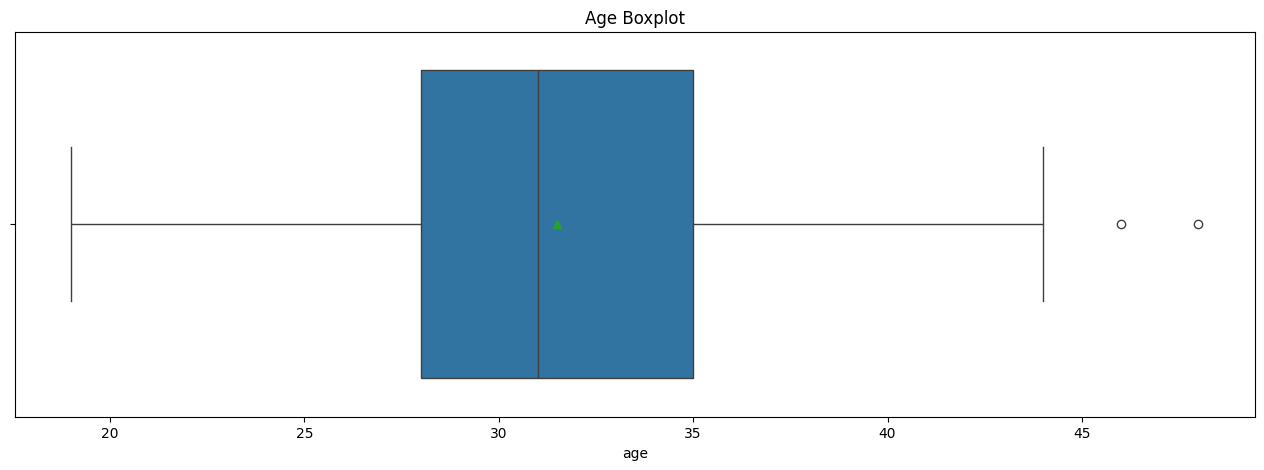

In [13]:
plt.figure(figsize=(16,5))
sns.boxplot(dataset, x='age', showmeans=True)
plt.title('Age Boxplot')
plt.show()

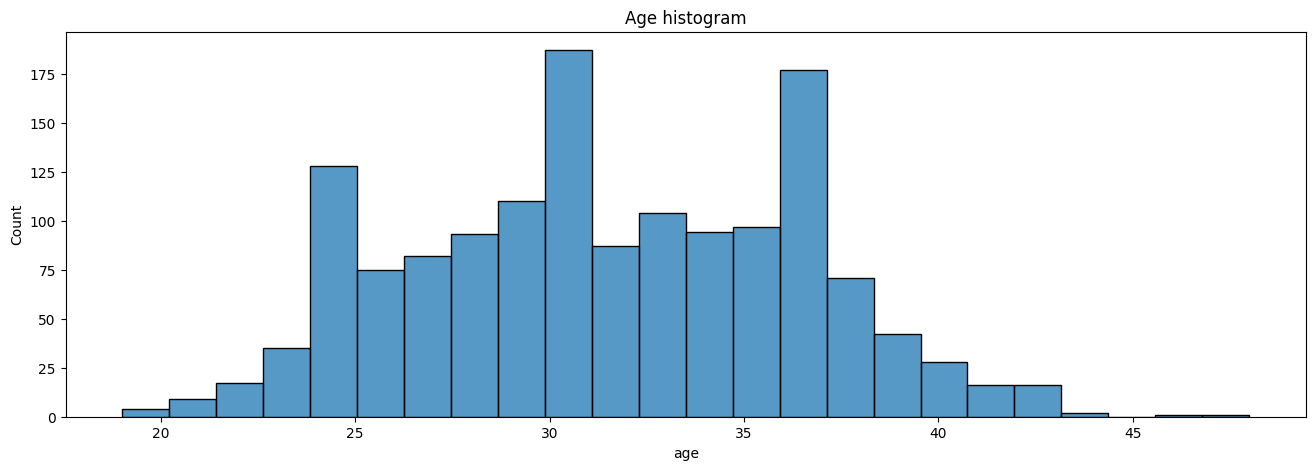

In [14]:
plt.figure(figsize=(16,5))
sns.histplot(dataset, x='age')
plt.title('Age histogram')
plt.show()

There are three peaks for age variable, age 25, age 30, and age around 37.

In [15]:
# check independent sample
for i in dataset['customer_id'].value_counts():
    if i > 1:
        print('not independent sample detected')
        break

The sample are independent and not counted twice.

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    1476 non-null   int64         
 1   register_date  1476 non-null   datetime64[ns]
 2   last_visit     1476 non-null   datetime64[ns]
 3   age            1476 non-null   int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 46.3 KB


## Data Preprocessing

In [17]:
dataset['duration'] = (pd.Series(dataset['last_visit']-dataset['register_date']).dt.days/30).astype('int')

In [18]:
print(dataset.head())

   customer_id register_date last_visit  age  duration
0         1001    2023-09-29 2023-10-21   27         0
1         1007    2023-11-28 2023-12-19   35         0
2         1011    2024-02-25 2024-03-20   28         0
3         1012    2023-07-30 2023-08-23   22         0
4         1033    2023-10-03 2023-10-22   29         0


To get duration, we need to subtrack the last_visit with register_date. Some people go to the fitness center once a week, twice a week, or even everyday. We count just one for both who visit everyday and once a week.

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    1476 non-null   int64         
 1   register_date  1476 non-null   datetime64[ns]
 2   last_visit     1476 non-null   datetime64[ns]
 3   age            1476 non-null   int64         
 4   duration       1476 non-null   int64         
dtypes: datetime64[ns](2), int64(3)
memory usage: 57.8 KB


In [20]:
print(dataset.describe())

       customer_id                  register_date  \
count  1476.000000                           1476   
mean   1738.500000  2023-07-03 17:11:13.170732032   
min    1001.000000            2022-11-07 00:00:00   
25%    1369.750000            2023-04-22 18:00:00   
50%    1738.500000            2023-07-03 00:00:00   
75%    2107.250000            2023-09-07 00:00:00   
max    2476.000000            2024-03-09 00:00:00   
std     426.228812                            NaN   

                          last_visit          age     duration  
count                           1476  1476.000000  1476.000000  
mean   2024-03-05 01:28:46.829268224    31.497967     7.644986  
min              2023-08-02 00:00:00    19.000000     0.000000  
25%              2023-11-24 00:00:00    28.000000     4.000000  
50%              2024-03-05 00:00:00    31.000000     7.000000  
75%              2024-06-23 00:00:00    35.000000    13.000000  
max              2024-10-01 00:00:00    48.000000    19.000000  
st

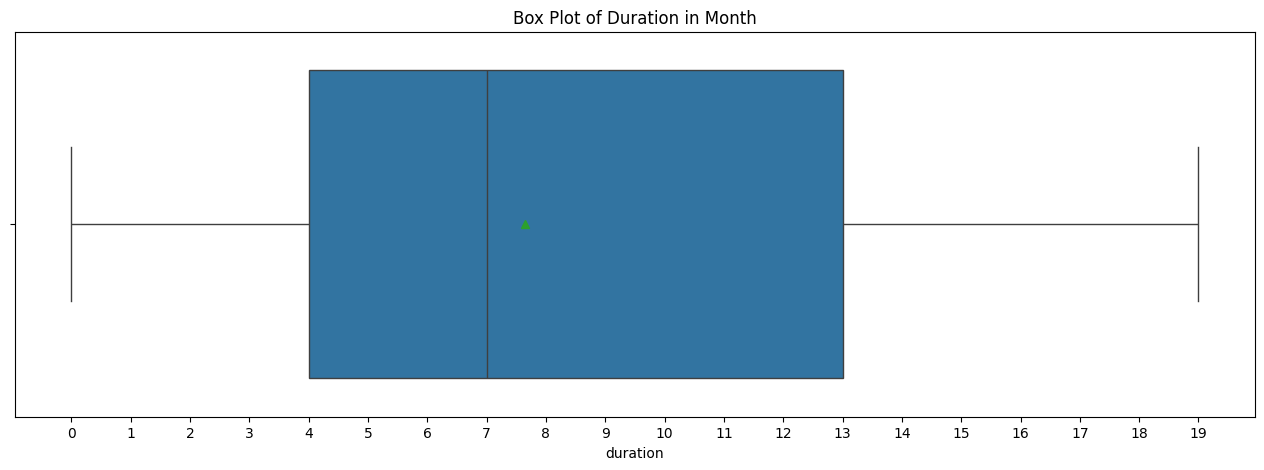

In [21]:
plt.figure(figsize=(16,5))
sns.boxplot(x=dataset['duration'], showmeans=True)
plt.xticks(range(0,(dataset['duration'].max()+1)))
plt.title('Box Plot of Duration in Month')
plt.show()

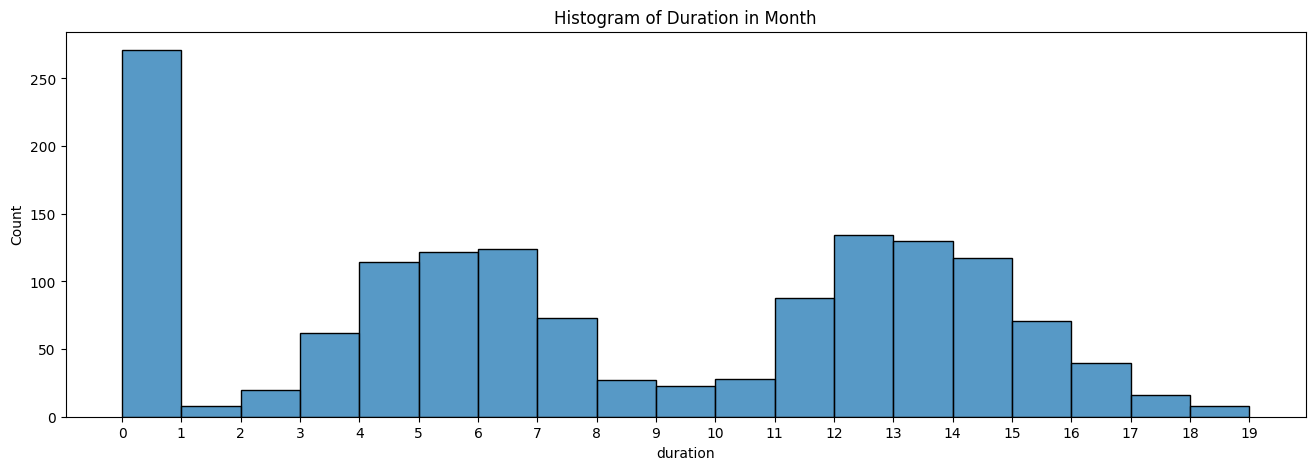

In [22]:
plt.figure(figsize=(16,5))
sns.histplot(dataset['duration'], bins=19)
plt.xticks(range(0,(dataset['duration'].max()+1)))
plt.title('Histogram of Duration in Month')
plt.show()

We still don't know yet they churn or not. What we know already is we have three peaks, the majority duration is one month, followed by 12 months and 6 months. If we remember the marketing team strategy, I guess that this one month duration group is the group that signed up to get the discount first month and then churn.

We query the dataset on '2024-10-01'. So, the churn statement point is '2024-04-01'. Last visit before churn statement point will count as churn.

In [23]:
def churn(x):
    if pd.Timestamp(x) < pd.Timestamp('2024-04-01'):
        return 1
    else:
        return 0

In [24]:
dataset['churn'] = dataset['last_visit'].apply(churn)

In [25]:
print(dataset)

      customer_id register_date last_visit  age  duration  churn
0            1001    2023-09-29 2023-10-21   27         0      1
1            1007    2023-11-28 2023-12-19   35         0      1
2            1011    2024-02-25 2024-03-20   28         0      1
3            1012    2023-07-30 2023-08-23   22         0      1
4            1033    2023-10-03 2023-10-22   29         0      1
...           ...           ...        ...  ...       ...    ...
1471         2462    2023-06-10 2024-08-21   33        14      0
1472         2465    2022-12-29 2024-05-11   41        16      0
1473         2467    2023-07-27 2024-09-14   39        13      0
1474         2473    2023-02-13 2024-04-02   40        13      0
1475         2474    2023-01-03 2024-04-29   37        16      0

[1476 rows x 6 columns]


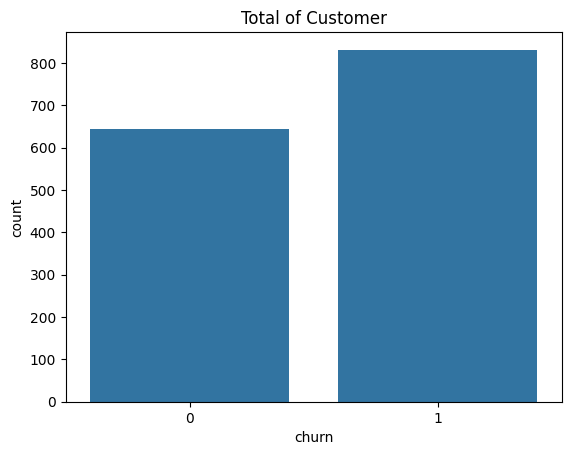

In [26]:
sns.barplot(dataset.churn.value_counts())
plt.title('Total of Customer')
plt.show()

In [27]:
dataset_clean = dataset[['age','duration','churn']].copy()

## Modeling

### Kaplan Meier Fitter Modelling

In [28]:
kmf = lifelines.KaplanMeierFitter()

In [29]:
kmf.fit(durations=dataset_clean['duration'],
        event_observed=dataset_clean['churn'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1476 total observations, 645 right-censored observations>

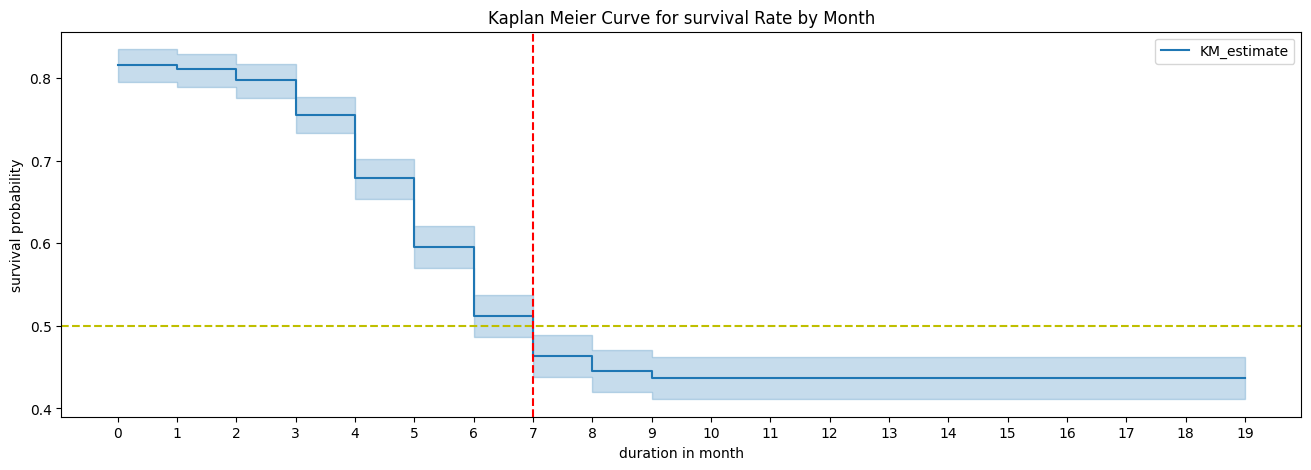

In [30]:
plt.figure(figsize=(16,5))
kmf.plot()
plt.xticks(range(0,(dataset_clean['duration'].max()+1)))
plt.xlabel('duration in month')
plt.ylabel('survival probability')
plt.axhline(y=0.5, c='y', linestyle='--')
plt.axvline(x=kmf.median_survival_time_, c='r', linestyle='--')
plt.title('Kaplan Meier Curve for survival Rate by Month')
plt.show()

We can see on duration 0, the survival probability did not start from 100%. It means the customers did not even extend for first month. After getting the 99% discount, they decided not to continue subscribing fitness center.

In [31]:
print(kmf.event_table)

          removed  observed  censored  entrance  at_risk
event_at                                                
0.0           271       271         0      1476     1476
1.0             8         8         0         0     1205
2.0            20        19         1         0     1197
3.0            62        62         0         0     1177
4.0           114       114         0         0     1115
5.0           122       122         0         0     1001
6.0           124       124         0         0      879
7.0            73        71         2         0      755
8.0            27        27         0         0      682
9.0            23        12        11         0      655
10.0           28         0        28         0      632
11.0           88         1        87         0      604
12.0          134         0       134         0      516
13.0          130         0       130         0      382
14.0          117         0       117         0      252
15.0           71         0    

From total 1476 customers, 271 customers of them stop subscribing after getting the discount 99%.

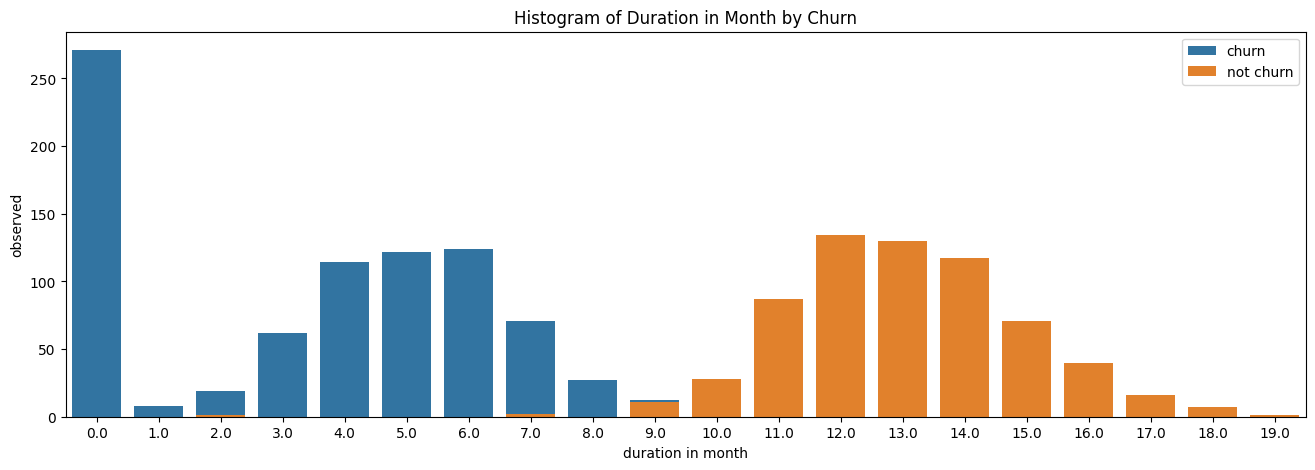

In [32]:
plt.figure(figsize=(16,5))
sns.barplot(y=kmf.event_table.observed, x=kmf.event_table.index, label='churn')
sns.barplot(y=kmf.event_table.censored, x=kmf.event_table.index, label='not churn')
plt.xlabel('duration in month')
plt.xticks(range(0,(dataset_clean['duration'].max()+1)))
plt.legend()
plt.title('Histogram of Duration in Month by Churn')
plt.show()

Month 0 with blue color has the most churn customers, followed by month 6. We see that after month 9 is cencored data which means they dont count as churn.

In [33]:
info

{'price': 199000, 'gross_profit': 0.55, 'first_month_discount': 0.99}

### CLTV Calculation

Regardless of ad cost, the Discount Cost would be like:

$$DC = ((1 - Gross \ Profit) * Price) - ((1 - First \ Month \ Discount) * Price)$$

I use Average Lifetime Customers as a parameter. But, because the duration is not normally distributed, I decide to use median, instead. We also don't use average customer order because we know already that the customer only purchase every month which we can just need the median of customer lifetime. The Customer Lifetime Value calculation would be:

$$CLTV = Price * Gross \ Profit * Median \ Lifetime$$

In [34]:
dc = (((1-info['gross_profit'])*info['price'])-((1-info['first_month_discount'])*info['price']))

In [35]:
cltv = (info['price'] * info['gross_profit'] * (kmf.median_survival_time_-1))

In [36]:
print(f"The Discount Cost: {int(dc)} IDR")
print(f"The Customer Lifetime Value: {int(cltv)} IDR")
print(f"The CLTV Ratio: {(cltv/dc).round(3)}")

The Discount Cost: 87559 IDR
The Customer Lifetime Value: 656700 IDR
The CLTV Ratio: 7.5


### cltv ratio

The customer lifetime value is simply a value that contributes to the profit of the company. This means, the price multiply by the gross profit and multiply by median lifetime. The standard ratio for CLTV is 3:1. In this case, the ratio is 7.5 which is very healthy for the company.

Note: in CLTV formula, we subtract one for the median lifetime because that is counted as the discount. So, the real median lifetime is 6 months.

### Cox Proportional Hazard Modelling

The CoxPHFitter is the module to analyze what factors contribute the most to the churn customers.

In [37]:
cox = lifelines.CoxPHFitter()
cox.fit(df=dataset_clean, duration_col='duration', event_col='churn')

<lifelines.CoxPHFitter: fitted with 1476 total observations, 645 right-censored observations>

In [38]:
cox.print_summary(style='ascii')

<lifelines.CoxPHFitter: fitted with 1476 total observations, 645 right-censored observations>
             duration col = 'duration'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 1476
number of events observed = 831
   partial log-likelihood = -5056.16
         time fit was run = 2025-02-07 13:48:54 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.35      0.71      0.01           -0.37           -0.33                0.69                0.72

           cmp to      z      p  -log2(p)
covariate                                
age          0.00 -34.52 <0.005    864.84
---
Concordance = 0.88
Partial AIC = 10114.32
log-likelihood ratio test = 1420.61 on 1 df
-log2(p) of ll-ratio test = 1030.32



There are so many things we can see but we will focus what's really important. From 1476 customers, we observed 831 customers that they do churn.

Coef uses logarithm so it's hard to interpret. But we see the minus in age coefficient which means everytime the age is increasing, the risk is getting decreasing, and vice versa. We use the exponential coefficient normalize the logarithm.

The exp(coef) is 0.71 which is smaller than 1. That means if the customer age is one year older, the risk or churn is (1-0.71= 0.29) 29% smaller than the younger customers. The P-value is less than 0.05 which means the variable age has a significant effect on duration of customer churn. The concordance says 0.88 or 88% which means the correlation coefficient is very well to predict the duration of churn using the model.

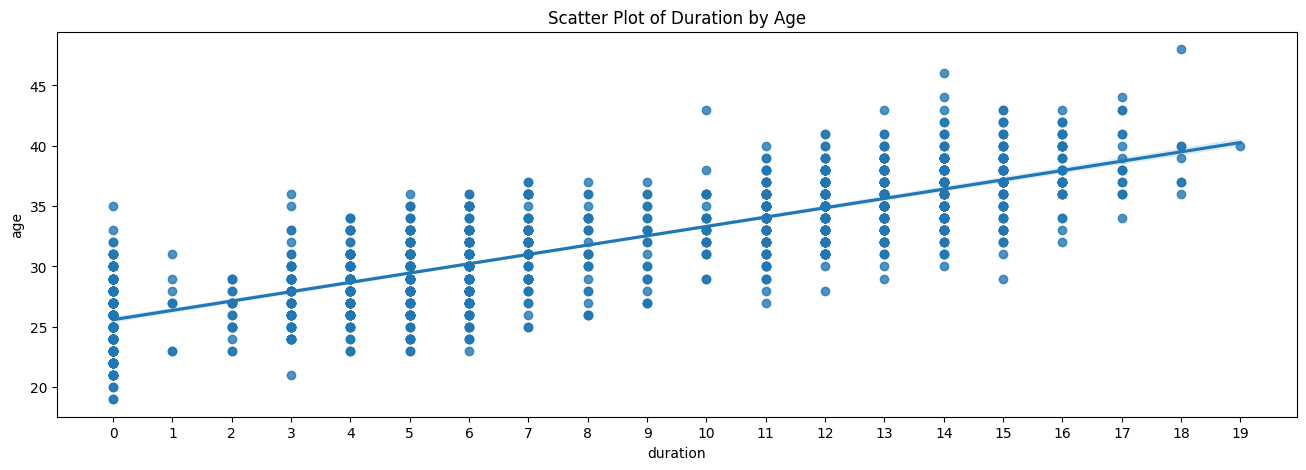

In [39]:
plt.figure(figsize=(16,5))
sns.regplot(dataset_clean, x='duration', y='age')
plt.xticks(range(0,(dataset_clean['duration'].max()+1)))
plt.title('Scatter Plot of Duration by Age')
plt.show()

## Insights

### Interpretation and Reporting
- 271 customers from 1476 decide not to continue the subscription.
- Because the duration is not normally distributed, we use non-parametric statistical technique which is Kaplan Meier method. The median of customer lifetime is 7 months or 6 months after one month discount. So, we just counted it as 6 months.
- The ratio of CLTV is 7.5 which is very good performance.
- The exponentiated coefficient (exp(coef)) for age was 0.71, indicating that for each one-year increase in customer age, the risk of churn decreased by 29% (1 - 0.71).
- This effect was statistically significant (p < .05).
- The model demonstrated good predictive ability, as indicated by a concordance statistic of 0.88.

### Action


# chatgpt

Berdasarkan hasil analisis survival yang disampaikan, berikut adalah beberapa **actionable insights** yang dapat membantu dalam pengambilan keputusan bisnis:

### 1. **Prioritaskan Retensi Pelanggan Muda**
   - **Insight**: Berdasarkan koefisien yang diekspresikan dalam exp(coef) = 0.71, risiko churn menurun seiring bertambahnya usia pelanggan. Artinya, pelanggan yang lebih muda memiliki kemungkinan lebih tinggi untuk berhenti berlangganan.
   - **Tindakan**: Fokuskan upaya retensi pada pelanggan yang lebih muda (misalnya di bawah 30 atau 35 tahun), dengan menawarkan paket atau diskon yang relevan. Pertimbangkan program loyalitas atau insentif yang dapat meningkatkan keterikatan mereka dengan layanan Anda.

### 2. **Menawarkan Diskon atau Manfaat untuk Meningkatkan Masa Langganan**
   - **Insight**: Durasi pelanggan bertahan rata-rata adalah sekitar 6 bulan setelah diberi diskon. Hal ini mengindikasikan bahwa insentif finansial seperti diskon dapat meningkatkan masa langganan, meskipun tidak menjamin retensi jangka panjang.
   - **Tindakan**: Pertimbangkan untuk menawarkan diskon berulang atau manfaat tambahan bagi pelanggan yang telah berlangganan lebih dari 6 bulan. Penawaran ini bisa mencakup diskon eksklusif atau akses ke fitur premium untuk menjaga mereka tetap terlibat.

### 3. **Perkuat Pengalaman Pelanggan pada Bulan Pertama**
   - **Insight**: Jika pelanggan sering berhenti setelah 6 bulan, kemungkinan besar ada faktor-faktor yang memengaruhi keputusan mereka untuk tidak melanjutkan berlangganan setelah masa diskon.
   - **Tindakan**: Fokuskan upaya untuk meningkatkan pengalaman pelanggan pada bulan pertama. Misalnya, melalui onboarding yang lebih baik, komunikasi yang lebih personal, atau bantuan proaktif untuk memastikan mereka merasa dihargai dan mendapatkan nilai maksimal dari langganan mereka.

### 4. **Segmentation Berdasarkan Usia untuk Penawaran yang Lebih Tepat Sasaran**
   - **Insight**: Efek usia pada risiko churn menunjukkan bahwa pelanggan yang lebih tua memiliki kemungkinan lebih rendah untuk berhenti berlangganan. Hal ini bisa mencerminkan bahwa mereka lebih loyal atau lebih puas dengan layanan.
   - **Tindakan**: Buat segmentasi yang lebih mendalam berdasarkan usia, dan tawarkan konten atau fitur yang lebih relevan untuk setiap kelompok usia. Misalnya, bagi pelanggan yang lebih tua, fokuskan pada nilai jangka panjang dari langganan atau kenyamanan penggunaan layanan.

### 5. **Optimalkan Prediksi Churn Berdasarkan Model Survival**
   - **Insight**: Model menunjukkan kemampuan prediktif yang baik dengan skor koncordansi 0.88, yang berarti model dapat memprediksi pelanggan yang kemungkinan besar akan churn dengan akurat.
   - **Tindakan**: Gunakan hasil model untuk memprediksi dan mengidentifikasi pelanggan yang berisiko tinggi untuk churn lebih awal. Dengan informasi ini, Anda bisa melakukan intervensi secara lebih proaktif (misalnya, memberikan penawaran khusus atau kontak pribadi) untuk mengurangi churn.

### 6. **Evaluasi Kinerja Program Diskon Secara Berkala**
   - **Insight**: Program diskon memiliki dampak positif pada retensi dalam jangka pendek (6 bulan), tetapi mungkin tidak cukup untuk menjaga pelanggan dalam jangka panjang.
   - **Tindakan**: Secara rutin evaluasi efektivitas program diskon dan pertimbangkan untuk memperkenalkan elemen baru yang mendukung nilai jangka panjang, seperti program referral atau integrasi fitur eksklusif yang lebih menarik.

### 7. **Menggunakan Median Pelanggan untuk Menentukan Titik Pemutusan**
   - **Insight**: Median waktu hidup pelanggan adalah 7 bulan (atau 6 bulan dengan diskon), yang berarti sebagian besar pelanggan bertahan dalam jangka waktu ini.
   - **Tindakan**: Gunakan informasi ini untuk merencanakan siklus pemasaran atau evaluasi produk, sehingga dapat lebih tepat mengantisipasi kapan pelanggan mungkin memutuskan untuk berhenti berlangganan dan menyesuaikan pendekatan pemasaran atau retensi.

### 8. **Monitor Perubahan dalam Risiko Churn Secara Berkala**
   - **Insight**: Karena model ini mengandalkan data historis dan faktor-faktor tertentu (seperti usia), perubahan dalam pola atau tren pelanggan bisa memengaruhi tingkat churn di masa depan.
   - **Tindakan**: Terus lakukan analisis survival secara berkala untuk menyesuaikan strategi bisnis sesuai dengan perubahan dalam data pelanggan atau faktor eksternal yang mungkin memengaruhi keputusan mereka untuk tetap berlangganan.

Dengan memperhatikan faktor-faktor ini, perusahaan dapat lebih baik dalam merencanakan strategi retensi pelanggan dan meminimalkan churn, sambil meningkatkan nilai seumur hidup pelanggan (CLTV).

# gemini

Here are some actionable insights based on your survival analysis results, geared towards making sound business decisions:

**1. Focus on Customer Retention within the First 6 Months:**

* **Insight:** The median customer lifetime is 6 months, indicating a high churn rate within this period.
* **Action:** Implement targeted retention strategies *within the first few months* of a customer's subscription. This could include:
    * **Onboarding improvements:**  Ensure a smooth and valuable initial experience.  Personalized onboarding based on customer segments could be beneficial.
    * **Proactive engagement:** Reach out to new customers with helpful tips, resources, or early access to new features.  This could be automated.
    * **Early feedback collection:**  Actively solicit feedback within the first month or two to identify and address potential pain points.
    * **Loyalty programs:** Introduce early incentives for continued subscription beyond the initial months.
    * **Targeted offers:** Offer personalized discounts or promotions to customers who show signs of disengagement within the first six months.

**2. Leverage Age as a Churn Predictor:**

* **Insight:** Older customers are significantly less likely to churn.
* **Action:**  Segment your customer base by age and tailor your marketing and retention efforts accordingly.
    * **Understand older customer needs:** Conduct research to understand *why* older customers are more loyal.  This could reveal valuable insights applicable to other segments.
    * **Target younger customers with tailored messaging:**  Craft messaging and offers that resonate with younger demographics, addressing their specific needs and concerns.  Perhaps younger customers value different features or have different price sensitivities.
    * **Consider age in acquisition strategy:** While you shouldn't discriminate based on age, you can use this insight to refine your targeting and potentially focus on acquiring customers who are more likely to stay long-term.

**3.  High CLTV Ratio - Capitalize on It (But Don't Get Complacent):**

* **Insight:** A CLTV ratio of 7.5 is excellent, suggesting that the lifetime value of a customer is significantly higher than the cost of acquiring them.
* **Action:**
    * **Invest in acquisition (smartly):**  Given the high CLTV, it makes sense to invest in customer acquisition.  However, ensure that acquisition costs remain aligned with the CLTV.  Don't overspend.
    * **Optimize acquisition channels:** Analyze which acquisition channels bring in the most valuable (long-lasting) customers.  Focus your resources on those channels.
    * **Monitor CLTV continuously:** While the current ratio is good, it's essential to monitor it over time.  Changes in churn rate or acquisition costs can impact CLTV.  Be prepared to adjust your strategies accordingly.

**4.  Address the Churn Rate:**

* **Insight:** While the CLTV is good, 271 out of 1476 customers churning is still a significant number.  Understanding *why* they churn is crucial.
* **Action:** Conduct thorough churn analysis:
    * **Exit surveys:** Implement exit surveys to understand the reasons behind churn.
    * **Analyze customer behavior:** Look for patterns in customer behavior before they churn (e.g., inactivity, decreasing usage of certain features).
    * **Compare churned vs. retained customers:** Identify key differences between these groups.
    * **A/B test retention strategies:** Experiment with different retention tactics to see which ones are most effective.

**5.  Kaplan-Meier and Non-Parametric Approach:**

* **Insight:** You correctly used a non-parametric approach due to the non-normal distribution of customer lifetime.
* **Action:** Continue to use appropriate statistical methods for your data.  This ensures that your insights are based on sound analysis.

By implementing these actions, you can leverage the insights from your survival analysis to improve customer retention, optimize acquisition strategies, and ultimately increase profitability. Remember to continuously monitor your metrics and adjust your approach as needed.


### Further Analysis